In [1]:
import ast
import codecs
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM,Concatenate,Multiply,Bidirectional,Dropout,Dense,Embedding,BatchNormalization,Dropout,GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

/home/fengyuan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/fengyuan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/fengyuan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/fengyuan/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.

In [4]:
!pwd

/home/fengyuan


In [6]:
df = pd.read_csv('/home/fengyuan/workspaceGServer/ATEC/data/for_nn.csv')
df.head(2)

,s1,s2,label,l1_no_oov,l2_no_oov,l1_idx,l2_idx
0,﻿怎么更改花呗手机号码,我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号,1,"['怎么', '更改', '手机号码']","['我', '的', '是', '以前', '的', '手机号码', '怎么', '更', ...","[176, 11047, 28645]","[8, 1, 5, 445, 1, 28645, 176, 123, 3981, 111, ..."
1,也开不了花呗，就这样了？完事了,真的嘛？就是花呗付款,0,"['也', '开', '不了', '就', '这样', '了', '完事', '了']","['真的', '嘛', '就是', '付款']","[27, 242, 666, 42, 131, 3, 14073, 3]","[143, 688, 23, 12050]"


In [ ]:
def load_dense_drop_repeat(path):
    vocab_size, size = 0, 0
    vocab = dict()
    vocab["i2w"], vocab["w2i"] = [], {}
    count = 0
    with codecs.open(path, "r", "utf-8") as f:
        first_line = True
        for line in f:
            if first_line:
                first_line = False
                vocab_size = int(line.strip().split()[0])
                size = int(line.rstrip().split()[1])
                matrix = np.zeros(shape=(vocab_size, size), dtype=np.float32)
                continue
            vec = line.strip().split()
            if not vocab["w2i"].__contains__(vec[0]):
                vocab["w2i"][vec[0]] = count
                matrix[count, :] = np.array([float(x) for x in vec[1:]])
                count += 1
    for w, i in vocab["w2i"].items():
        vocab["i2w"].append(w)
    return matrix, vocab, size, len(vocab["i2w"])

matrix, vocab, size, length = load_dense_drop_repeat('/home/fengyuan/workspaceGServer/ATEC/word2vec/sgns.zhihu.word')

In [109]:
# embedding matrix
matrix.shape # OHE->EMD

(259922, 300)

In [110]:
# vocab list
len(vocab['i2w'])  # list: [word1, word2 ...]

259836

In [111]:
# word to index
len(vocab['w2i'])  # dict: {word: index}

259836

In [112]:
length

259836

In [113]:
df['l1_idx'] = df['l1_idx'].apply(lambda x:ast.literal_eval(x) )
df['l2_idx'] = df['l2_idx'].apply(lambda x:ast.literal_eval(x) )

In [114]:
l1_padded = pad_sequences(df['l1_idx'], padding='post', maxlen=15, truncating='post')
l2_padded = pad_sequences(df['l2_idx'], padding='post', maxlen=15, truncating='post')
y = df['label'].tolist()

In [115]:
len(l1_padded),len(l2_padded),len(y)

(102477, 102477, 102477)

In [116]:
X_train_l1 = np.array(l1_padded[:81898])
X_train_l2 = np.array(l2_padded[:81898])
X_val_l1 = np.array(l1_padded[81898:])
X_val_l2 = np.array(l2_padded[81898:])
y_train = np.array(y[:81898]).reshape(-1,1)
y_val = np.array(y[81898:]).reshape(-1,1)
X_train_l1.shape,X_val_l1.shape,len(y_train),len(y_val)

((81898, 15), (20579, 15), 81898, 20579)

In [117]:

#https://zhuanlan.zhihu.com/p/103623160
def focal_loss(y_true, y_pred):
    gamma = 2.0
    alpha = 0.8
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))

In [118]:
input1 = Input(shape=(None,), dtype="int32")
input2 = Input(shape=(None,), dtype="int32")


x1_1 = Embedding(input_dim = matrix.shape[0], # 字典长度
                            output_dim=matrix.shape[1], # 词向量 长度（300）
                            weights=[matrix], # 重点：预训练的词向量系数
                            input_length=15, # 每句话的 最大长度（必须padding）
                            trainable=False # 是否在 训练的过程中 更新词向量
                            )(input1)

x2_1 = Embedding(input_dim = matrix.shape[0], # 字典长度
                            output_dim=matrix.shape[1], # 词向量 长度（300）
                            weights=[matrix], # 重点：预训练的词向量系数
                            input_length=15, # 每句话的 最大长度（必须padding）
                            trainable=False # 是否在 训练的过程中 更新词向量
                            )(input2)

x1_2 = LSTM(units=12,return_sequences=False,activation='tanh')(x1_1)
x2_2 = LSTM(units=12,return_sequences=False,activation='tanh')(x2_1)
x_3 = Multiply()([x1_2,x2_2])
#x_4 = Dense(8,activation='elu')(x_3)
x_5 = Dense(1,activation='sigmoid')(x_3)
model = Model(inputs=[input1,input2], outputs=x_5)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, None, 300)    77976600    input_15[0][0]                   
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, None, 300)    77976600    input_16[0][0]                   
__________________________________________________________________________________________________
lstm_14 (L

In [119]:
opt=Adam(0.005)

model.compile(loss=[focal_loss],optimizer=opt,metrics=['accuracy'])

In [120]:
# performance decay scheduling
# lr = lr*0.5 if val_loss does not decrease in 5 consequtive epochs
# can work with Adam
lr_scheduler_pfm = ReduceLROnPlateau(factor=0.5, patience=2)

# save the model when the performance on val is the best
checkpoint_callback = ModelCheckpoint('/home/fengyuan/workspaceGServer/ATEC/model/dual_lstm.h5', save_best_only=True)

# stop train when there is no progress in 3 consecutive epochs
early_stop_callback = EarlyStopping(patience=3)


In [121]:
history = model.fit([X_train_l1,X_train_l2], y_train, epochs=16 ,batch_size=32, validation_data=([X_val_l1,X_val_l2], y_val), callbacks=[lr_scheduler_pfm, checkpoint_callback,early_stop_callback])

Train on 81898 samples, validate on 20579 samples
Epoch 1/16
81898/81898 [==============================] - 189s 2ms/step - loss: 1.7329 - acc: 0.7095 - val_loss: 1.6349 - val_acc: 0.8377

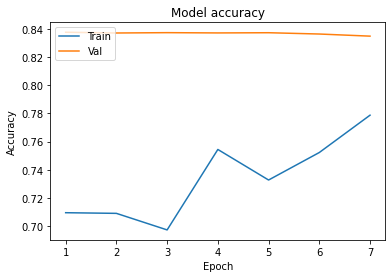

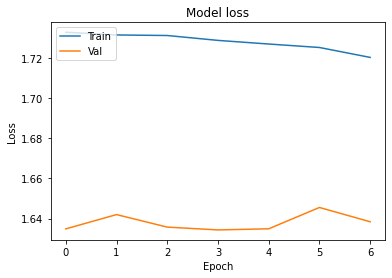

In [123]:
from matplotlib import pyplot as plt
epoch_range=range(1,7+1)
plt.plot(epoch_range,history.history['acc'])
plt.plot(epoch_range,history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Val'],loc='upper left')
plt.show()

In [124]:
y_pred = model.predict([X_val_l1,X_val_l2])

In [125]:
y_val_eval = y_val.flatten()
y_pred_eval = y_pred.flatten()

In [126]:
from ATEC/code/evaluation import BinClsEvaluation

bce = BinClsEvaluation(y_pred_eval,y_val_eval)

ModuleNotFoundError: No module named 'evaluation'

In [ ]:
bce.confusion_matrix()


In [ ]:
bce.roc_curve()